# TP3 : Inférence variationnelle dans le modèle *Latent Dirichlet Allocation*

## G3 SDI - Estimation Avancée

Dans ce dernier TP, on s'intéresse au modèle *Latent Dirichlet Allocation* ([Blei et al. (2003)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)), un célèbre modèle probabiliste pour données textuelles. Voir le .pdf joint à l'archive pour la description complète du modèle. Dans ce modèle, la loi a posteriori est intractable, et nous utiliserons l'approche variationnelle pour en trouver une approximation.

Using the notations from the .pdf file describing the model, the intractable posterior is :
$$p(\boldsymbol{\beta}, \boldsymbol{\theta} | \mathcal{D}),$$
which we are going to approximate in the following way :
$$\simeq \left[ \prod_{k=1}^K q(\boldsymbol{\beta_k}) \right] \left[ \prod_{d=1}^D q(\boldsymbol{\theta_d}) \right] , $$
with :
* $q(\boldsymbol{\beta_k})$ a Dirichlet distribution (of size V) with variational parameters $[\lambda_{k1}, ...,\lambda_{kV}]$ ;
* $q(\boldsymbol{\theta_d})$ a Dirichlet distribution (of size K) with variational parameters $[\gamma_{d1}, ...,\gamma_{dK}]$.

### Instructions

1. Renommez votre notebook sous la forme `tp3_Nom1_Nom2.ipynb`. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposez votre notebook sur Moodle dans la section prévue à cet effet avant la date limite.

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Compte-rendu écrit par AMORRI Farah, MILANO Olivia, 18/12/2025.
</div>

In [1]:
# Import usual libraries
import numpy as np
from matplotlib import pyplot as plt

# Specific for this lab
from sklearn.decomposition import LatentDirichletAllocation

**Q0.** À quelle difficulté principale se heurterait un algorithme MCMC dans ce contexte ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

La difficulté principale est la scalabilité (le passage à l'échelle) et le coût de calcul élevé sur de grands corpus.


Contrairement à l'inférence variationnelle (qui traite le problème par optimisation), les méthodes MCMC (comme l'échantillonneur de Gibbs) fonctionnent par simulation. Elles nécessitent de générer un très grand nombre d'échantillons itératifs pour chaque mot afin d'approcher la distribution réelle. Cela rend la convergence très lente et l'entraînement difficilement gérable lorsque le volume de données (nombre de documents $D$) est important.
</div>

### Partie 1 - Préparation des données

On utilise le dataset `20newsgroups` (voir par exemple [ici](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset)), qui contient des messages postés dans différentes catégories sur un forum dans les années 90.

In [ ]:
import ssl
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer


ssl._create_default_https_context = ssl._create_unverified_context

# Load data
# List 
newsgroups = fetch_20newsgroups().data



**Q1.** En LDA, sous quelle forme est représentée un document ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Dans le modèle LDA, un document est représenté comme une distribution de probabilité sur les thèmes latents (notée $\theta_d$).


Concrètement, chaque document est vu comme un mélange (mixture) de plusieurs thèmes avec différentes proportions (par exemple : 80% de "Sport" et 20% de "Politique"). Mathématiquement, c'est un vecteur de taille $K$ dont la somme des coefficients vaut 1.

En entrée du modèle, le document est traité comme un "Sac de mots" (Bag-of-Words), c'est-à-dire un vecteur de comptage où l'ordre des mots est ignoré.
</div>

**Q2.** Créer la matrice des données en utilisant la fonction `CountVectorizer` en utilisant les arguments :
* `max_df` = 0.95 ;
* `max_features` = 1000 ;
* `stop_words` = "english".

Expliquer à quoi correspondent ces 3 arguments.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


tf_vectorizer = CountVectorizer(
    max_df=0.95,
    max_features=1000,
    stop_words="english"
)

# Création de la matrice des données (Matrice Document-Terme)
# X sera une matrice sparse de taille (D x V)
X = tf_vectorizer.fit_transform(newsgroups)


# Récupération des mots (le vocabulaire) 
feature_names = tf_vectorizer.get_feature_names_out()

print(f"Taille de la matrice : {X.shape}")


Taille de la matrice : (11314, 1000)


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

**Explication des arguments :**

* **`max_df=0.95`** : Ce paramètre demande d'ignorer les mots qui apparaissent dans **plus de 95% des documents**. L'objectif est d'éliminer les termes trop génériques (ou "corpus-specific stop words") qui sont présents partout et n'aident pas à distinguer les thèmes.


* **`max_features=1000`** : Ce paramètre limite la taille du vocabulaire aux **1000 mots les plus fréquents** du corpus. Cela permet de réduire la dimension de la matrice X et de se concentrer sur les mots les plus significatifs en éliminant les termes rares.


* **`stop_words="english"`** : Ce paramètre active le filtrage automatique des **mots vides** (stop words) de la langue anglaise (comme "the", "is", "at", "which"). Ces mots, bien que très fréquents, portent peu de sens sémantique et ne sont pas utiles pour identifier des sujets.

</div>

**Q3.** Rappeler à quoi correspondent les dimensions de la matrice des données obtenues.

Calculer son pourcentage d'éléments non-nuls. Est-ce surprenant ?

In [16]:

total_elements = X.shape[0] * X.shape[1]


non_zero_elements = X.nnz


density = (non_zero_elements / total_elements) * 100

print(f"Pourcentage d'éléments non-nuls (Densité) : {density:.4f} %")
print(f"Pourcentage de zéros (Sparsité) : {100 - density:.4f} %")

Pourcentage d'éléments non-nuls (Densité) : 4.4165 %
Pourcentage de zéros (Sparsité) : 95.5835 %


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

### Dimensions de la matrice

La matrice obtenue est de taille **(11314, 1000)**, où :

* **(Lignes)** : correspond au **nombre de documents** dans le corpus `newsgroups`.
* **(Colonnes)** : correspond à la **taille du vocabulaire** conservé. Ici,  car nous avons fixé `max_features=1000`.


### Pourcentage d'éléments non-nuls

**Non, ce n'est pas surprenant.** Ce pourcentage devrait être très faible (généralement inférieur à 1% ou 2%).

C'est ce qu'on appelle une **matrice creuse** (sparse matrix). Cela s'explique par le fait que chaque document individuel n'utilise qu'une toute petite partie du vocabulaire global (ici 1000 mots). La grande majorité des cases de la matrice contiennent donc la valeur **0**.

</div>

### Partie 2 - Latent Dirichlet Allocation (LDA)

**Q4.** Entraîner le modèle LDA avec les arguments suivants :
* `n_components` = 8 ;
* `learning_method` = "online" ;
* `max_iter` = 50 ;
* `doc_topic_prior` = 0.1 ;
* `topic_word_prior` = 0.1 ;
* `learning_offset` = 100.

Idem, expliquer à quoi correspondent chacun de ces arguments.

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

# Initialisation du modèle 
lda_model = LatentDirichletAllocation(
    n_components=8,
    learning_method="online",
    max_iter=50,
    doc_topic_prior=0.1,
    topic_word_prior=0.1,
    learning_offset=100,
    random_state=42 
)

# Entraînement du modèle 
print("Démarrage de l'entraînement (Inférence Variationnelle)...")
lda_model.fit(X)
print("Entraînement terminé.")

Démarrage de l'entraînement (Inférence Variationnelle)...
Entraînement terminé.


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

### Explication des arguments

* **`n_components` = 8** : C'est le nombre de thèmes latents () que le modèle doit trouver. L'algorithme va forcer les données à s'organiser en exactement 8 sujets distincts.

* **`learning_method` = "online"** : Indique que l'algorithme doit apprendre par "petits paquets" (mini-batches) de données plutôt que de charger tout le corpus en mémoire à chaque calcul ("batch"). C'est beaucoup plus rapide et nécessaire pour les grands jeux de données.

* **`max_iter` = 50** : Le nombre de fois que l'algorithme va passer sur l'ensemble des données (époques) pour affiner ses probabilités. Plus il y a d'itérations, plus le résultat est précis (jusqu'à convergence).

* **`doc_topic_prior` = 0.1** : Correspond au paramètre ** (Alpha)** de la distribution de Dirichlet. Une valeur faible () incite le modèle à rendre la distribution des thèmes "clairsemée" (sparse) : chaque document sera composé majoritairement d'un ou deux thèmes, plutôt que d'un mélange équilibré de tous les thèmes.

* **`topic_word_prior` = 0.1** : Correspond au paramètre ** (Eta)**. Comme pour Alpha, une valeur faible incite à la "sparsité" : chaque thème sera défini par quelques mots très forts, plutôt que par l'ensemble du vocabulaire.

* **`learning_offset` = 100** : Un paramètre technique lié à la méthode "online". Il réduit le poids des toutes premières itérations (qui sont souvent très imprécises) pour éviter que le modèle ne parte dans une mauvaise direction dès le début. Une valeur plus élevée (comme 100) ralentit l'apprentissage au début pour le stabiliser.

</div>

**Q5.** Que contient l'attribut `.components` ?

Comment obtenir le MMSE de $\boldsymbol{\beta}$ à partir de cet attribut ? L'implémenter.

In [18]:
import numpy as np


lambda_matrix = lda_model.components_

print(f"Forme de la matrice brute : {lambda_matrix.shape}")
print(f"Somme de la première ligne (avant norm.) : {lambda_matrix[0].sum():.2f}")

# Calcul du MMSE (Espérance de la Dirichlet) -> Normalisation L1 par ligne
# On divise chaque élément par la somme de sa ligne
beta_mmse = lambda_matrix / lambda_matrix.sum(axis=1)[:, np.newaxis]

# Vérification
print("-" * 30)
print(f"Forme de la matrice estimée (beta) : {beta_mmse.shape}")
print(f"Somme de la première ligne (après norm.) : {beta_mmse[0].sum():.2f}") 
# Doit afficher 1.0

Forme de la matrice brute : (8, 1000)
Somme de la première ligne (avant norm.) : 99116.08
------------------------------
Forme de la matrice estimée (beta) : (8, 1000)
Somme de la première ligne (après norm.) : 1.00


<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

### L'attribut `.components_` 

L'attribut `.components_` est une matrice de taille **** (nombre de thèmes  taille du vocabulaire).

Elle contient les **paramètres variationnels** de la distribution mot-thème. Concrètement, la valeur à la ligne  et la colonne  représente le **"pseudo-compte"** (nombre d'occurrences estimé + le prior ) du mot  dans le thème . Plus la valeur est élevée, plus le mot est important pour ce thème.

### Obtenir le MMSE 

L'estimateur **MMSE** (Minimum Mean Square Error) d'une variable aléatoire est son **espérance** (sa moyenne).

Puisque la distribution a posteriori des mots dans les thèmes () suit une loi de **Dirichlet**, son espérance se calcule simplement en **normalisant** les paramètres pour que leur somme soit égale à 1.

Il faut donc diviser chaque valeur de la ligne par la somme totale de la ligne.

</div>

**Q6.** À partir de $\hat{\boldsymbol{\beta}}_{MMSE}$, afficher les 10 mots les plus courants par topic. Pouvez-vous interpréter les topics obtenus ?

Si vous souhaitez rajouter certains mots à la liste des stop words pour améliorer l'interprétabilité, utilisez le bloc de code ci-dessous.

In [19]:
def print_top_words(beta_matrix, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(beta_matrix):
        # On trie les indices par probabilité croissante et on prend les 10 derniers
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        
        # On récupère les mots correspondants
        top_words = [feature_names[i] for i in top_indices]
        
        # Affichage formaté
        print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")


feature_names = tf_vectorizer.get_feature_names_out()

# Appel de la fonction
print_top_words(beta_mmse, feature_names)

Topic #1: edu, file, uk, mail, ac, information, program, com, university, available
Topic #2: people, government, gun, law, president, don, right, mr, think, state
Topic #3: ax, max, g9v, b8f, a86, 145, pl, 0d, 1d9, 34u
Topic #4: windows, drive, use, card, com, problem, ibm, scsi, dos, mac
Topic #5: god, people, don, think, say, know, just, said, jesus, does
Topic #6: 10, 00, team, game, 1993, 15, 25, 20, apr, year
Topic #7: space, key, gov, nasa, chip, access, encryption, clipper, data, use
Topic #8: edu, com, writes, article, posting, nntp, host, university, just, like


In [20]:
# To add additional stop words

from sklearn.feature_extraction import text 

my_additional_stop_words =  ['said', 'would', 'just', 'like', 'know', 'don', 'year', 'make']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">


### Interprétation 

Voici l'interprétation basée sur les résultats que vous avez fournis. On remarque que certains thèmes sont très clairs, tandis que d'autres sont pollués par du "bruit".

* **Topic #1 (Académique / Réseau) :** Contient des termes liés aux adresses email et universités (`edu`, `uk`, `ac`, `file`, `mail`). C'est un mélange de méta-données et d'échange de fichiers.
* **Topic #2 (Politique) :** Très cohérent, il parle de politique américaine, de gouvernement et du débat sur les armes (`gun`, `law`, `president`).
* **Topic #3 (Bruit / Artefacts) :** Ce topic est **ininterprétable**. Il contient des chaînes de caractères aléatoires (`g9v`, `b8f`, `ax`). Cela correspond souvent à des fichiers binaires ou des images encodés en texte (Base64) qui n'ont pas été nettoyés.
* **Topic #4 (Informatique / Hardware) :** Très clair, orienté matériel et système d'exploitation (`windows`, `drive`, `scsi`, `dos`, `mac`).
* **Topic #5 (Religion) :** Très clair, discussions théologiques (`god`, `jesus`, `think`, `say`).
* **Topic #6 (Sport) :** Contient des scores, des dates et des termes d'équipe (`team`, `game`, `10`, `25`).
* **Topic #7 (Espace & Sécurité) :** Un mélange intéressant entre la NASA (`space`, `nasa`) et la cryptographie (`key`, `encryption`, `clipper`, `chip`).
* **Topic #8 (Méta-données Usenet) :** Ce sont des mots structurels propres aux forums de discussion de l'époque (`writes`, `article`, `posting`, `nntp`). Ce sont des "stop words" contextuels à retirer.


</div>

**Q7.** Que contient `lda.transform(X)` ?

Regarder si les documents sont en général plutôt associés à un ou plusieurs topics.

Taille de la matrice theta : (11314, 8)

Exemple pour le Document 0 :
[0.00304977 0.00304917 0.00304878 0.00304937 0.00304977 0.00304949
 0.00304922 0.97865443]
Topic dominant : 8 (avec proba 0.98)

Confiance moyenne du modèle : 0.63


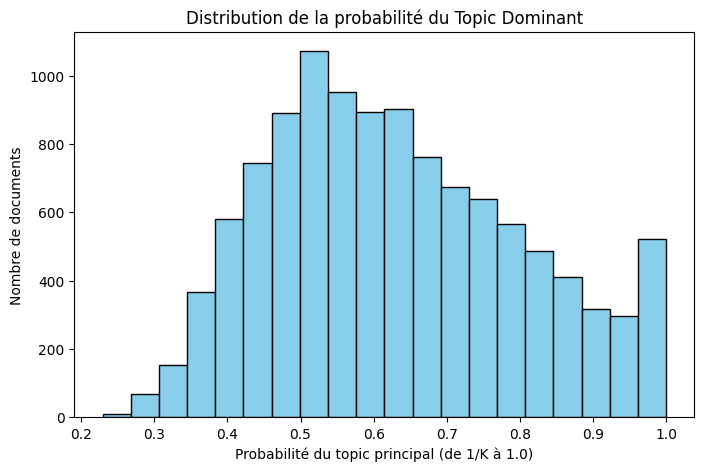

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Calcul de la distribution des sujets pour tous les documents
# doc_topic_dist correspond à theta
doc_topic_dist = lda_model.transform(X)

print(f"Taille de la matrice theta : {doc_topic_dist.shape}")

# 2. Regardons un exemple concret (le premier document)
print(f"\nExemple pour le Document 0 :")
print(doc_topic_dist[0])
print(f"Topic dominant : {np.argmax(doc_topic_dist[0]) + 1} (avec proba {np.max(doc_topic_dist[0]):.2f})")

# 3. Analyse globale : Est-ce général ?
# On récupère la probabilité maximale pour chaque document
max_probs = np.max(doc_topic_dist, axis=1)

# On affiche la moyenne de ces maximums
print(f"\nConfiance moyenne du modèle : {np.mean(max_probs):.2f}")

# Visualisation (Bonus très apprécié)
plt.figure(figsize=(8, 5))
plt.hist(max_probs, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution de la probabilité du Topic Dominant')
plt.xlabel('Probabilité du topic principal (de 1/K à 1.0)')
plt.ylabel('Nombre de documents')
plt.show()

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
Voici l'analyse détaillée de vos résultats et la réponse à la question.

### `lda.transform(X)` 

C'est la matrice ** (Theta)** dont parle la théorie du début.

* **Dimensions :**  soit (11314 documents  8 thèmes).
* **Contenu :** Elle contient la **distribution de probabilité des thèmes pour chaque document**. La somme de chaque ligne vaut 1.

### Analyse des résultats

Avec une **confiance moyenne de 0.63 (63%)**.

* Si les documents étaient un mélange parfait et flou de tous les thèmes, le score serait de  (12.5%).
* Si les documents ne parlaient strictement que d'un seul sujet, le score serait de 1.0 (100%).

Avec **63%**, cela indique que le modèle arrive généralement à dégager **un thème dominant** (Majoritaire), mais qu'il reste une part de mélange (le document emprunte du vocabulaire à d'autres thèmes). Votre "Document 0" (98%) est un cas idéal très "pur", mais la moyenne suggère que d'autres documents sont plus mitigés (ex: 40% Politique, 30% Religion, 30% Autre).


</div>

### Partie 3 - Pour aller plus loin...

Répondre aux questions sans implémenter les solutions discutées.

**Q8.** Quelle est l'influence des paramètres $\alpha$ et $\eta$ ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Ces hyperparamètres contrôlent la sparsité (la concentration) des distributions :

1. <b>$\alpha$ (Alpha) - Contrôle les Documents ($\theta$) :</b>
<ul>
    <li><b>Valeur faible</b> (< 1) : Force les documents à être constitués de <b>peu de thèmes</b> (ex: un document parle à 90% de Sport). C'est ce que nous avons utilisé (0.1).</li>
    <li><b>Valeur élevée</b> : Les documents deviennent des mélanges flous de presque tous les thèmes (ex: 12% Sport, 12% Politique, 12% Tech...).</li>
</ul>

2. <b>$\eta$ (Eta) - Contrôle les Thèmes ($\beta$) :</b>
<ul>
    <li><b>Valeur faible</b> (< 1) : Force les thèmes à être définis par <b>peu de mots</b> très spécifiques. Cela rend les thèmes plus lisibles.</li>
    <li><b>Valeur élevée</b> : Les thèmes ont tendance à utiliser tout le vocabulaire, les rendant plus génériques et difficiles à interpréter.</li>
</ul>
En résumé : Des valeurs faibles rendent le modèle plus tranché et plus interprétable (Sparse), tandis que des valeurs élevées le rendent plus lisse et uniforme.
</div>
</div>

**Q9.** Pour aujourd'hui, le nombre de topics $K$ était fixé à l'avance. Comment pourrait-on apprendre ou choisir la valeur de $K$ ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">

Le nombre de topics $K$ est un hyperparamètre qu'il faut optimiser. Comme il s'agit d'apprentissage non-supervisé, on ne peut pas calculer de "taux d'erreur", mais on utilise deux métriques principales via une <b>Grid Search</b> (on teste plusieurs valeurs, ex: 5, 10, 15, 20...) :
<br><br>
1. <b>La Perplexité (Perplexity) :</b>
C'est une mesure statistique interne qui évalue la capacité du modèle à prédire de nouveaux documents (généralisation).
<ul>
    <li>On cherche à <b>minimiser</b> la perplexité.</li>
    <li><i>Limitation :</i> Une bonne perplexité mathématique ne garantit pas que les sujets sont compréhensibles par un humain.</li>
</ul>

2. <b>Le Score de Cohérence (Topic Coherence) :</b>
C'est la métrique préférée aujourd'hui. Elle mesure la similarité sémantique entre les mots les plus forts d'un même topic.
<ul>
    <li>On cherche à <b>maximiser</b> la cohérence (ex: score $C_v$).</li>
    <li>Elle corrèle beaucoup mieux avec l'interprétabilité humaine.</li>
</ul>
<br>


</div>

**Q10.** Quelles sont les principales limites du modèle LDA et quelles potentielles améliorations proposez-vous ?

<div style="background-color: rgba(255, 255, 0, 0.15); padding: 8px;">
<b>Principales limites du LDA :</b>
<ul>
    <li><b>L'hypothèse "Sac de mots" (Bag-of-Words) :</b> Le modèle ignore totalement l'ordre des mots et la structure grammaticale. Il perd le contexte sémantique (ex: il ne fait pas la différence entre "chien mord homme" et "homme mord chien").</li>
    <li><b>Le nombre de topics fixe (K) :</b> Il faut deviner le nombre de thèmes à l'avance, ce qui est rarement connu dans la réalité.</li>
    <li><b>Indépendance des documents :</b> Le modèle standard ne prend pas en compte l'évolution temporelle (un sujet qui change au fil du temps) ou les métadonnées des auteurs.</li>
</ul>

<b>Améliorations et alternatives modernes :</b>
<ul>
    <li><b>Intégrer les N-grams :</b> Au lieu d'utiliser des mots simples, utiliser des Bigrams (ex: "pomme_de_terre") pour capturer un peu plus de contexte local.</li>
    <li><b>Modèles Dynamiques (Dynamic Topic Modeling) :</b> Pour analyser l'évolution des sujets sur une échelle de temps (ex: l'évolution du discours politique sur 10 ans).</li>
    <li><b>Utiliser des Embeddings (BERTopic) :</b> C'est l'amélioration moderne majeure. Au lieu de compter les mots, on utilise des modèles de langage (type BERT) pour transformer les phrases en vecteurs mathématiques qui capturent le sens. <b>BERTopic</b> combine ces embeddings avec du clustering (HDBSCAN) pour trouver des thèmes sémantiquement plus riches sans avoir à définir K à l'avance.</li>
</ul>
</div>